In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
import warnings
warnings.filterwarnings("ignore")

In [2]:
channels = ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']

In [3]:
epochs_ica_folder = 'gameemo_database_epochs_ica'
current_dir = epochs_ica_folder 
labels_path = 'GameLabels\GAMEEMO_SCORES.xlsx'
labels_sheet = 'All'
labels_file = pd.read_excel(labels_path, labels_sheet)
labels_file.head(2)

,Subject,Boring,Horrible,Calm,Funny
0,1,8,1,3,2
1,1,2,1,8,8


In [4]:
labels_array = np.array(labels_file[['Boring', 'Horrible', 'Calm', 'Funny']])
labels_array[0]

array([8, 1, 3, 2], dtype=int64)

In [5]:
from sklearn.decomposition import FastICA, PCA
import pywt

In [6]:
# Parameters
sampling_rate = 128  # Adjust based on the actual sampling rate of your data
widths = np.arange(1, 25)  # Example widths, adjust based on your needs

In [7]:
# Function to perform PCA
def perform_pca(signal, n_components):
    pca = PCA(n_components=n_components)
    return pca.fit_transform(signal)

In [8]:
def compute_cwt(signal, widths):
    cwt_matrices = []
    for i in range(signal.shape[0]):  # Loop over each channel
        coef, _ = pywt.cwt(signal[i, :], widths, 'cmor')
        # coef = cv2.resize(np.abs(coef), (100, 1), interpolation=cv2.INTER_LINEAR)
        cwt_matrices.append(coef)
    return np.stack(cwt_matrices, axis=-1)

In [9]:
subject = os.listdir(current_dir)[0]
game = os.listdir(os.path.join(current_dir, subject))[0]
epoch = os.listdir(os.path.join(current_dir, subject, game))[0]
read_epoch = pd.read_csv(os.path.join(current_dir, subject, game, epoch))

In [10]:
read_epoch = read_epoch[channels].T.values
print(read_epoch.shape)

(14, 641)


In [11]:
pca_signal = perform_pca(np.transpose(read_epoch), n_components=read_epoch.shape[0] // 2)
spectrogram = compute_cwt(np.transpose(pca_signal), widths)

In [12]:
print(pca_signal.shape)
spectrogram.shape

(641, 7)


(24, 641, 7)

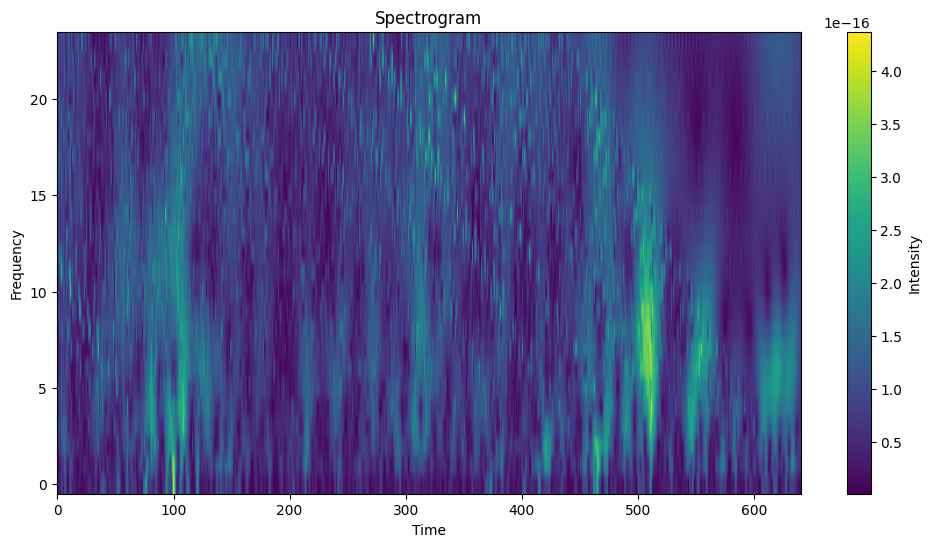

In [13]:
# Plot the spectrogram
plt.figure(figsize=(12, 6))
plt.imshow(np.abs(spectrogram[:, :, 2]), aspect='auto', cmap='viridis', origin='lower')
plt.title("Spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(label='Intensity')
plt.show()

In [14]:
epochs_data = []
labels_data = []

k=0

for subject in tqdm(os.listdir(current_dir)):
    for game in os.listdir(os.path.join(current_dir, subject)):
        k+=1
        for epoch in os.listdir(os.path.join(current_dir, subject, game)):
            read_epoch = pd.read_csv(os.path.join(current_dir, subject, game, epoch))
            read_epoch = read_epoch[channels].T.values
            pca_signal = perform_pca(np.transpose(read_epoch), n_components=read_epoch.shape[0] // 2)
            spectrogram = compute_cwt(np.transpose(pca_signal), widths)
            epochs_data.append(np.array(np.abs(spectrogram)))
            labels_data.append(labels_array[k-1])

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [02:47<00:00,  5.97s/it]


In [15]:
print((epochs_data[0].shape), (labels_data[0].shape))

(24, 641, 7) (4,)


In [16]:
main_data = np.array(epochs_data)
main_labels = np.array(labels_data)
print(main_data.shape, main_labels.shape)

(6608, 24, 641, 7) (6608, 4)


In [17]:
row_size = main_data.shape[1]
col_size = main_data.shape[2]
print(row_size, col_size)

24 641


In [33]:
from sklearn.model_selection import train_test_split

# First, split into training+validation and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(main_data[0:5000], main_labels[0:5000], test_size=0.2, random_state=42)

# Then, split the training+validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# Print the shapes of the resulting datasets
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (3000, 24, 641, 7) (3000, 4)
Validation set shape: (1000, 24, 641, 7) (1000, 4)
Testing set shape: (1000, 24, 641, 7) (1000, 4)


In [19]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

In [20]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [26]:
# def EEGNet(nb_classes = 4, Chans = 14, Samples = 129, 
#              dropoutRate = 0.5, kernLength = 64, F1 = 8, 
#              D = 4, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
def EEGNet(nb_classes = 4, Row_size = row_size, Col_size = col_size, Chans = 7, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 4, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input_main   = Input((row_size, col_size, Chans))
    block1       = Conv2D(25, (5, 5), padding='same',
                                 input_shape=(row_size, col_size, Chans),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    # block1       = Conv2D(25, (Chans, 1),
    #                              kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block1)
    block1       = Activation('elu')(block1)
    block1       = MaxPooling2D(pool_size=(2, 2), padding='same',strides=(2, 2))(block1)
    block1       = Dropout(dropoutRate)(block1)
  
    block2       = Conv2D(50, (5, 5), padding='same',
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block2       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block2)
    block2       = Activation('elu')(block2)
    block2       = MaxPooling2D(pool_size=(2, 2), padding='same',strides=(2, 2))(block2)
    block2       = Dropout(dropoutRate)(block2)
    
    block3       = Conv2D(100, (5, 5), padding='same',
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block2)
    block3       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block3)
    block3       = Activation('elu')(block3)
    block3       = MaxPooling2D(pool_size=(2, 2), padding='same',strides=(2, 2))(block3)
    block3       = Dropout(dropoutRate)(block3)
    
    # block4       = Conv2D(200, (5, 5), padding='same',
    #                              kernel_constraint = max_norm(2., axis=(0,1,2)))(block3)
    # # block4       = Conv2D(25, (Chans, 1),
    # #                              kernel_constraint = max_norm(2., axis=(0,1,2)))(block4)
    # block4       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block4)
    # block4       = Activation('elu')(block4)
    # block4       = MaxPooling2D(pool_size=(2, 2), padding='same',strides=(1, 1))(block4)
    # block4       = Dropout(dropoutRate)(block4)
    
    flatten      = Flatten()(block3)
    
    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    output      = Activation('linear')(dense)
    
    return Model(inputs=input_main, outputs=output)


In [27]:
eegnet_model = EEGNet()

In [28]:
eegnet_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24, 641, 7)]      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 641, 25)       4400      
                                                                 
 batch_normalization_3 (Batc  (None, 24, 641, 25)      100       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 24, 641, 25)       0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 12, 321, 25)      0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 12, 321, 25)       0   

In [29]:
eegnet_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [30]:
eegnet_model.fit(X_train, y_train, epochs=400, batch_size=16, validation_data=(X_val, y_val))

Epoch 1/400
188/188 [==============================] - 5s 24ms/step - loss: 11.1940 - accuracy: 0.2937 - val_loss: 10.5997 - val_accuracy: 0.2630
Epoch 2/400
188/188 [==============================] - 4s 20ms/step - loss: 10.7573 - accuracy: 0.2953 - val_loss: 9.0850 - val_accuracy: 0.3020
Epoch 3/400
188/188 [==============================] - 4s 20ms/step - loss: 9.2242 - accuracy: 0.3200 - val_loss: 8.7002 - val_accuracy: 0.3170
Epoch 4/400
188/188 [==============================] - 4s 20ms/step - loss: 8.7020 - accuracy: 0.3210 - val_loss: 9.0534 - val_accuracy: 0.3080
Epoch 5/400
188/188 [==============================] - 4s 20ms/step - loss: 8.6643 - accuracy: 0.3133 - val_loss: 8.5384 - val_accuracy: 0.3000
Epoch 6/400
188/188 [==============================] - 4s 20ms/step - loss: 8.5364 - accuracy: 0.3283 - val_loss: 8.2883 - val_accuracy: 0.3280
Epoch 7/400
188/188 [==============================] - 4s 20ms/step - loss: 8.4585 - accuracy: 0.3250 - val_loss: 8.2482 - val_accura

In [34]:
y_pred = eegnet_model.predict(X_test)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
y_pred

In [ ]:
y_test